In [506]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from scipy.stats import norm
from sklearn.metrics import r2_score

In [507]:
# Laste poll-of-polls data
df = pd.read_csv("../data/pollofpolls_mai.csv", sep=";")

In [508]:
#df = df[2:]

In [509]:
df

,Mnd,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
0,Mai-25,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8
1,April-25,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9
2,Mars-25,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4
3,Februar-25,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2
4,Januar-25,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
...,...,...,...,...,...,...,...,...,...,...,...
204,Mai-08,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
205,April-08,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
206,Mars-08,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
207,Februar-08,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0


In [510]:
# tom dict for prediksjoner
predictions = {"Mnd": ["Juni-25","Juli-25","August-25","September-25"]}

In [511]:
###for å kunne konvertere til dato datatype
month_mapping = {
    "Januar": "January", "Februar": "February", "Mars": "March", "April": "April",
    "Mai": "May", "Juni": "June", "Juli": "July", "August": "August",
    "September": "September", "Oktober": "October", "November": "November", "Desember": "December"
}

# Replace Norwegian months with English
df["Mnd"] = df["Mnd"].replace(month_mapping, regex=True)

In [512]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"], format="%B-%y").dt.to_period("M").dt.to_timestamp("M")

# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [513]:
df

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-01-31,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,0.0
2008-02-29,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,0.0
2008-03-31,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,0.0
2008-04-30,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,0.0
2008-05-31,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-01-31,19.1,22.2,24.1,8.0,5.9,3.4,4.5,3.3,5.6,3.9
2025-02-28,24.8,18.4,24.6,7.4,6.6,3.0,4.2,2.4,5.4,3.2
2025-03-31,28.1,18.8,22.7,7.2,4.9,3.1,4.3,2.7,4.6,3.4


In [514]:
# Perform ADF test on each party's time series
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'Sp', 'KrF', 'Venstre', 'MDG','Rodt', 'Andre']: 
    result = adfuller(df[party])
    print(f"{party} ADF Statistic: {result[0]}, p-value: {result[1]}")
    if result[1] > 0.05:
        print(f"Warning: {party} is not stationary, consider differencing.")

Ap ADF Statistic: -1.8602548014009044, p-value: 0.3509831532396106
Hoyre ADF Statistic: -2.3297032751609517, p-value: 0.16256692684655105
Frp ADF Statistic: -1.9192719009094594, p-value: 0.3230500151069807
SV ADF Statistic: -1.4248806053478122, p-value: 0.570291643100021
Sp ADF Statistic: -1.618716145945923, p-value: 0.47340243743296
KrF ADF Statistic: -1.9776328278230375, p-value: 0.2964656061587814
Venstre ADF Statistic: -2.866997506475116, p-value: 0.04932253736294415
MDG ADF Statistic: -1.628853332131231, p-value: 0.4680909819558237
Rodt ADF Statistic: -0.7437064122413051, p-value: 0.8351015529405694
Andre ADF Statistic: -1.6328240087869437, p-value: 0.4660128626439931


In [515]:
df_diff = df.diff().dropna()  # Difference to make stationary

In [516]:
df_diff

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-02-29,-0.3,0.1,1.3,-0.7,-0.2,-0.1,0.1,0.0,0.0,0.0
2008-03-31,-0.3,0.8,0.0,0.3,-0.3,-0.2,-0.3,0.0,-0.2,0.0
2008-04-30,0.3,-1.2,0.2,-0.5,-0.1,0.9,0.5,0.0,0.1,0.0
2008-05-31,-0.1,0.9,0.5,0.2,0.2,-0.8,-0.6,0.0,0.2,0.0
2008-06-30,-2.9,-0.2,3.0,0.2,-0.4,-0.1,-0.3,0.0,0.4,0.0
...,...,...,...,...,...,...,...,...,...,...
2025-01-31,1.9,1.0,-1.3,-1.4,0.6,-0.5,-0.8,0.2,-0.2,0.4
2025-02-28,5.7,-3.8,0.5,-0.6,0.7,-0.4,-0.3,-0.9,-0.2,-0.7
2025-03-31,3.3,0.4,-1.9,-0.2,-1.7,0.1,0.1,0.3,-0.8,0.2


In [517]:
# ADF test on each column of df_diff
for col in df_diff.columns:
    result = adfuller(df_diff[col])
    print(f'{col}: p-value={result[1]}')

Ap: p-value=1.614951691184648e-26
Hoyre: p-value=3.4796045927506372e-12
Frp: p-value=5.025596502382313e-25
SV: p-value=2.1441642984720848e-22
Sp: p-value=9.084081837707712e-29
KrF: p-value=2.6446090685095454e-25
Venstre: p-value=4.925124766025841e-26
MDG: p-value=3.11266678125114e-29
Rodt: p-value=8.745593064013835e-14
Andre: p-value=8.654017269734014e-30


In [518]:
model = VAR(df_diff)  
model_fitted = model.fit(maxlags=4,method = 'ols', trend='n', verbose=True)

# Display the summary of the fitted model
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 03, Jun, 2025
Time:                     21:32:18
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -6.15248
Nobs:                     204.000    HQIC:                  -10.0268
Log likelihood:          -1203.46    FPE:                3.34799e-06
AIC:                     -12.6586    Det(Omega_mle):     5.58711e-07
--------------------------------------------------------------------
Results for equation Ap
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
L1.Ap             -1.554670         0.440923           -3.526           0.000
L1.Hoyre          -1.599543         0.441546           -3.623           0.000
L1.Frp            -1.604053         0.442337           -3.626           0.0

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [519]:
# Compute R² for each party
r2_scores = {}
for party in df_diff.columns:
    r2_scores[party] = r2_score(df_diff[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.2363
R² for Hoyre: 0.2310
R² for Frp: 0.1922
R² for SV: 0.3184
R² for Sp: 0.1881
R² for KrF: 0.4383
R² for Venstre: 0.3090
R² for MDG: 0.2487
R² for Rodt: 0.3114
R² for Andre: 0.2887


In [520]:
# Compute MAE, MSE, RMSE, and MAPE for each party
mae_scores = {}
mse_scores = {}
rmse_scores = {}

for party in df_diff.columns:
    actual = df_diff[party].iloc[model_fitted.k_ar:]
    predicted = model_fitted.fittedvalues[party]
    
    mae_scores[party] = mean_absolute_error(actual, predicted)
    mse_scores[party] = mean_squared_error(actual, predicted)
    rmse_scores[party] = np.sqrt(mse_scores[party])  # RMSE

# Print MAE, MSE, RMSE, and MAPE values
for party in df_diff.columns:
    print(f"MAE for {party}: {mae_scores[party]:.4f}")
    print(f"MSE for {party}: {mse_scores[party]:.4f}")
    print(f"RMSE for {party}: {rmse_scores[party]:.4f}")


MAE for Ap: 0.9599
MSE for Ap: 1.6974
RMSE for Ap: 1.3029
MAE for Hoyre: 0.8521
MSE for Hoyre: 1.2281
RMSE for Hoyre: 1.1082
MAE for Frp: 0.8358
MSE for Frp: 1.1330
RMSE for Frp: 1.0644
MAE for SV: 0.2967
MSE for SV: 0.1464
RMSE for SV: 0.3827
MAE for Sp: 0.5569
MSE for Sp: 0.6612
RMSE for Sp: 0.8131
MAE for KrF: 0.2171
MSE for KrF: 0.0856
RMSE for KrF: 0.2927
MAE for Venstre: 0.2849
MSE for Venstre: 0.1291
RMSE for Venstre: 0.3594
MAE for MDG: 0.2199
MSE for MDG: 0.0901
RMSE for MDG: 0.3001
MAE for Rodt: 0.2931
MSE for Rodt: 0.1539
RMSE for Rodt: 0.3923
MAE for Andre: 0.2456
MSE for Andre: 0.1106
RMSE for Andre: 0.3326


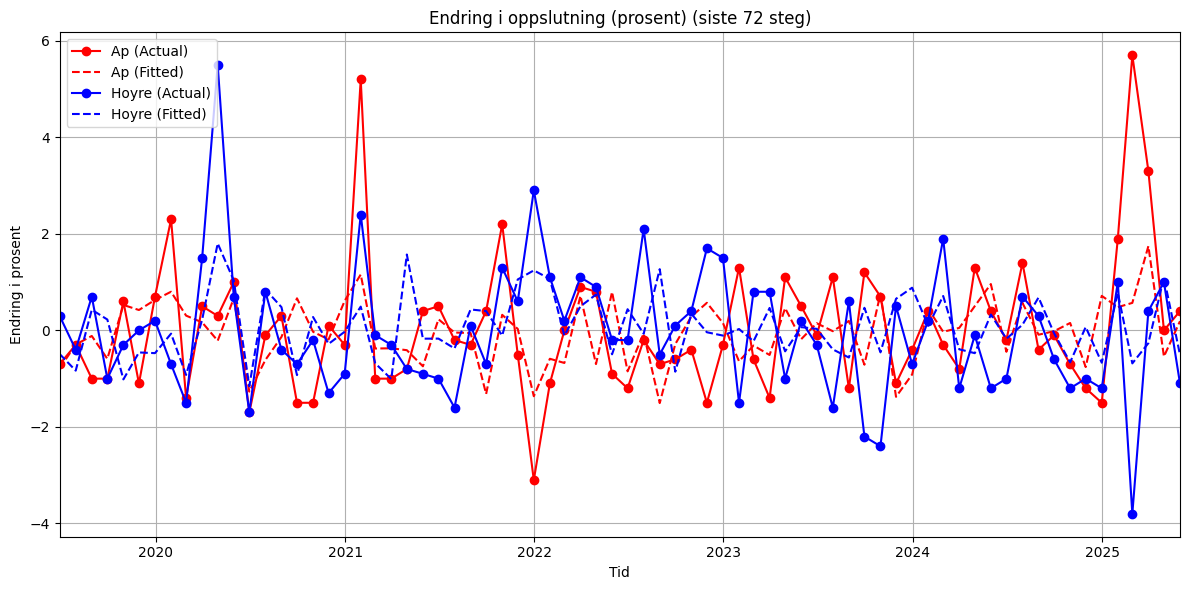

In [521]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
}

# Number of time steps to plot back in time
steps = 72

# Get fitted values (predicted changes in differenced scale)
fitted_values = model_fitted.fittedvalues[-steps:]

# Create a figure for plotting
plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]

    # Extract actual data for the last 'steps' data points
    actual_data = df_diff[party].iloc[-steps:]
    
    # Plot actual data (last 'steps' points)
    plt.plot(df_diff.index[-steps:], actual_data, marker="o", color=color, label=f"{party} (Actual)")

    # Plot fitted values (dashed line)
    plt.plot(fitted_values.index, fitted_values[party], linestyle="dashed", color=color, label=f"{party} (Fitted)")

    # Calculate the R-squared value between actual and fitted values
    r2 = r2_score(actual_data, fitted_values[party])

    # Print the R-squared value on the plot
    #plt.text(0.9, 0.1, f"R²: {r2:.4f}", transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom')

plt.xlim(df.index[-steps], df.index[-1])  # Set x-axis range to last 'steps' records
plt.xlabel("Tid")
plt.ylabel("Endring i prosent")
plt.title("Endring i oppslutning (prosent) (siste 72 steg)")

# Show the legend
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


In [522]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [523]:
steps = 4  # Number of steps to forecast
alpha = 0.50

forecast, lower, upper = model_fitted.forecast_interval(df_diff.values[-model_fitted.k_ar:], steps=steps, alpha=alpha)

# Convert forecasted values to DataFrames
forecast_dates = pd.date_range(start="2025-06-30", periods=steps, freq='ME')

forecast_diff_df = pd.DataFrame(forecast, index=forecast_dates, columns=df.columns)
forecast_lower_diff_df = pd.DataFrame(lower, index=forecast_dates, columns=df.columns)
forecast_upper_diff_df = pd.DataFrame(upper, index=forecast_dates, columns=df.columns)

# Convert predictions back to original scale
last_actual_value = df.iloc[-1]  # Last known actual data point

forecast_original_scale = forecast_diff_df.cumsum() + last_actual_value
forecast_lower_original_scale = forecast_lower_diff_df.cumsum() + last_actual_value
forecast_upper_original_scale = forecast_upper_diff_df.cumsum() + last_actual_value


In [524]:
# Get forecast covariance in differenced scale
forecast_cov_diff = model_fitted.forecast_cov(steps=steps)

# Initialize original scale covariance matrix
forecast_cov_original_scale = np.zeros_like(forecast_cov_diff)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov_original_scale[t] = np.sum(forecast_cov_diff[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_original_df = {t: pd.DataFrame(forecast_cov_original_scale[t], index=df.columns, columns=df.columns)
                            for t in range(steps)}


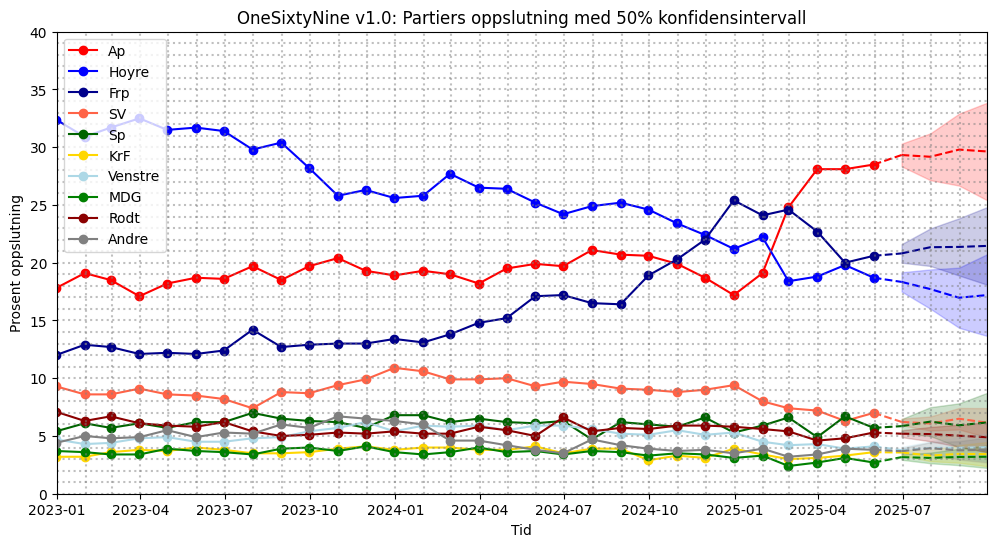

In [525]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'Sp': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df.index, df[party], marker="o", color=color, label=f"{party}")

    # Plot forecast (original scale)
    plt.plot(forecast_original_scale.index, forecast_original_scale[party], linestyle="dashed", color=color)

    last_actual_date = df.index[-1]
    first_forecast_date = forecast_original_scale.index[0]
    last_actual_value = df[party].iloc[-1]
    first_forecast_value = forecast_original_scale[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_original_scale.index, 
                     forecast_lower_original_scale[party], 
                     forecast_upper_original_scale[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS")  # "MS" = Month Start
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2023-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v1.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [526]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-06-30,29.324546,18.338348,20.805798,6.217152,5.852462,3.569106,3.776154,3.167991,5.194939,3.685178
2025-07-31,29.173950,17.717350,21.342915,6.079918,6.241949,3.306334,3.967348,3.098785,5.162761,3.938379
2025-08-31,29.793207,16.969547,21.369140,6.492888,5.927771,3.445604,3.982008,3.183321,5.022298,3.755214
2025-09-30,29.634355,17.197196,21.455365,6.151257,6.168125,3.425917,4.024163,3.200367,4.893335,3.795866


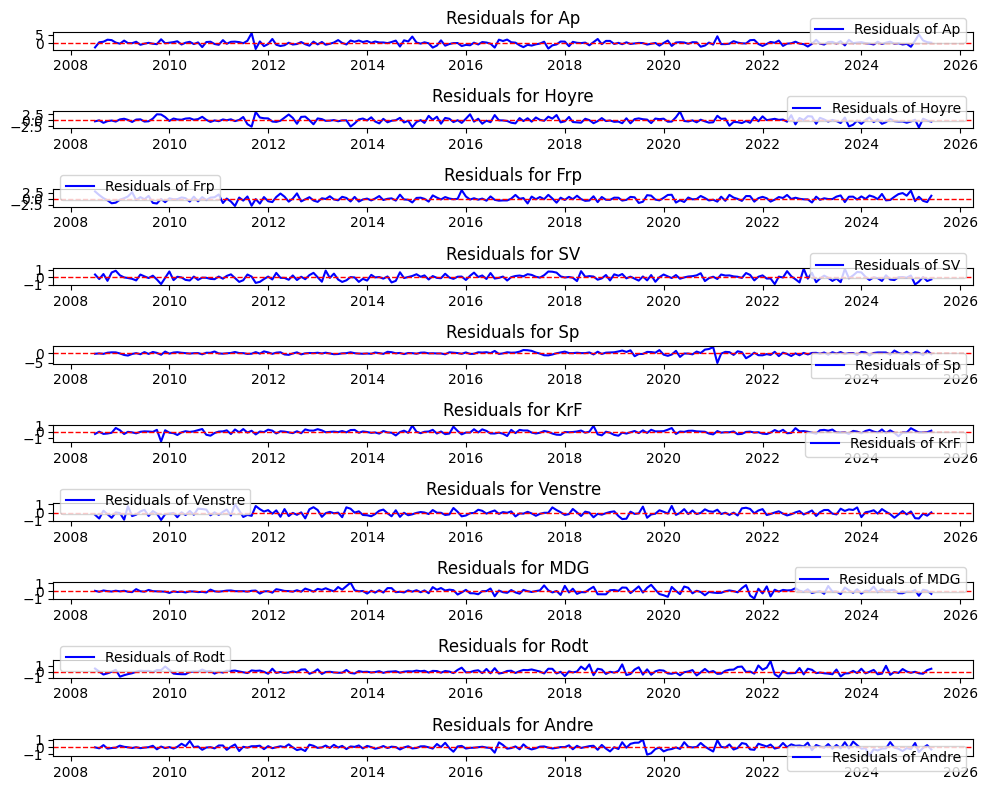

In [527]:
# Get residuals from the fitted model
residuals = model_fitted.resid  # Residuals for all variables

# Plot residuals for each variable
fig, axes = plt.subplots(nrows=residuals.shape[1], ncols=1, figsize=(10, 8))

for i, col in enumerate(residuals.columns):
    axes[i].plot(residuals.index, residuals[col], label=f"Residuals of {col}", color="blue")
    axes[i].axhline(y=0, linestyle="--", color="red", linewidth=1)
    axes[i].set_title(f"Residuals for {col}")
    axes[i].legend()

plt.tight_layout()
plt.show()

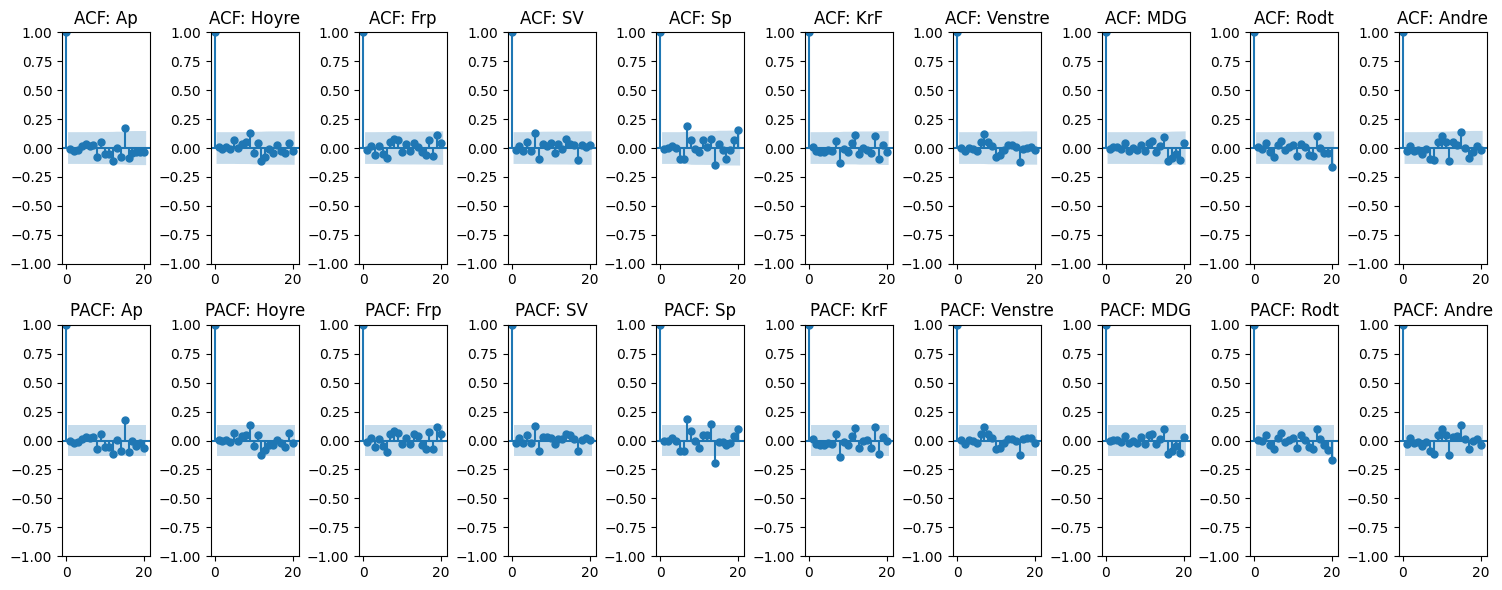

In [528]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF & PACF for residuals of the first variable
fig, axes = plt.subplots(nrows=2, ncols=residuals.shape[1], figsize=(15, 6))

for i, col in enumerate(residuals.columns):
    plot_acf(residuals[col], ax=axes[0, i], lags=20, title=f"ACF: {col}")
    plot_pacf(residuals[col], ax=axes[1, i], lags=20, title=f"PACF: {col}")

plt.tight_layout()
plt.show()

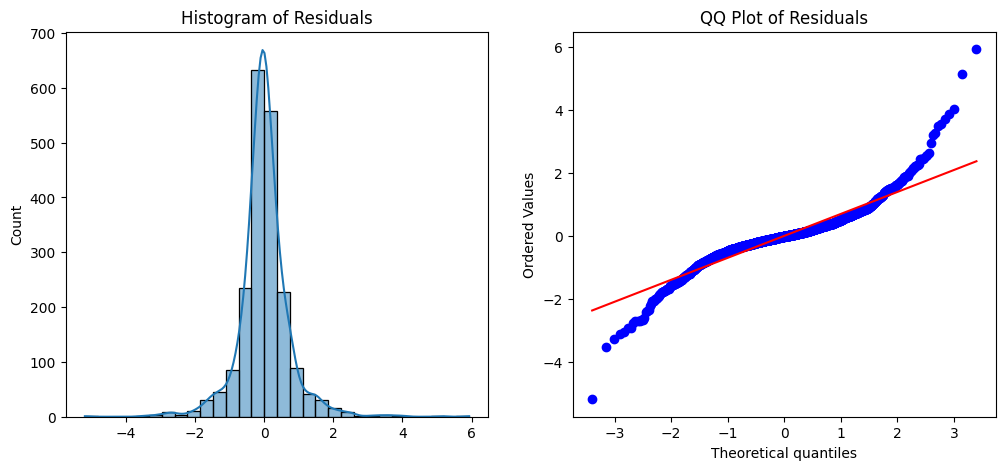

In [529]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Histogram of residuals
sns.histplot(residuals.values.flatten(), kde=True, ax=axes[0], bins=30)
axes[0].set_title("Histogram of Residuals")

# QQ Plot
stats.probplot(residuals.values.flatten(), dist="norm", plot=axes[1])
axes[1].set_title("QQ Plot of Residuals")

plt.show()


In [530]:
forecast_lower_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-06-30,28.344457,17.504707,20.005073,5.929284,5.240768,3.348957,3.505812,2.942228,4.899824,3.434967
2025-07-31,27.147361,16.016673,19.718183,5.474962,4.993572,2.818026,3.391355,2.637995,4.544666,3.419549
2025-08-31,26.680203,14.365570,18.892535,5.562457,4.031918,2.681979,3.093409,2.471709,4.068922,2.959449
2025-09-30,25.422267,13.666607,18.102678,4.891767,3.609438,2.376869,2.819224,2.234694,3.602544,2.711204


In [531]:
forecast_upper_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-06-30,30.304636,19.171988,21.606523,6.505021,6.464156,3.789255,4.046497,3.393753,5.490053,3.935389
2025-07-31,31.200538,19.418026,22.967648,6.684873,7.490326,3.794643,4.543342,3.559576,5.780855,4.457208
2025-08-31,32.906211,19.573523,23.845744,7.423319,7.823624,4.209229,4.870607,3.894933,5.975675,4.550978
2025-09-30,33.846443,20.727785,24.808052,7.410748,8.726811,4.474964,5.229102,4.166040,6.184125,4.880529


In [532]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_original_scale.loc[date_to_extract]
lower_row = forecast_lower_original_scale.loc[date_to_extract]
upper_row = forecast_upper_original_scale.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
print(result_df)


     Party   Estimate      Lower      Upper
0       Ap  29.634355  25.422267  33.846443
1    Hoyre  17.197196  13.666607  20.727785
2      Frp  21.455365  18.102678  24.808052
3       SV   6.151257   4.891767   7.410748
4       Sp   6.168125   3.609438   8.726811
5      KrF   3.425917   2.376869   4.474964
6  Venstre   4.024163   2.819224   5.229102
7      MDG   3.200367   2.234694   4.166040
8     Rodt   4.893335   3.602544   6.184125
9    Andre   3.795866   2.711204   4.880529


In [533]:
forecast_original_scale

,Ap,Hoyre,Frp,SV,Sp,KrF,Venstre,MDG,Rodt,Andre
2025-06-30,29.324546,18.338348,20.805798,6.217152,5.852462,3.569106,3.776154,3.167991,5.194939,3.685178
2025-07-31,29.173950,17.717350,21.342915,6.079918,6.241949,3.306334,3.967348,3.098785,5.162761,3.938379
2025-08-31,29.793207,16.969547,21.369140,6.492888,5.927771,3.445604,3.982008,3.183321,5.022298,3.755214
2025-09-30,29.634355,17.197196,21.455365,6.151257,6.168125,3.425917,4.024163,3.200367,4.893335,3.795866


In [534]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
#yhat_vector = forecast_original_scale["Estimate"].values  # Mean estimates for all parties
cov_matrix = forecast_cov_original_scale[-1]  # Covariance matrix at final step (latest forecast)

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)/sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)/sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.7395


In [535]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [536]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [537]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [538]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [539]:
sample_mandate['Sum']=sample_mandate.sum(axis=1)

In [540]:
sample_169=sample_mandate[sample_mandate["Sum"]==169].copy()

In [541]:
sample_169['red_green'] = sample_169[["Ap", "SV", "Sp", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "Sp"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "Sp", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "Sp", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "Sp", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [542]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [543]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())

0.7384469286429464
0.0005677184942041103
0.06848749470989585
0.5405196172545134
0.7384469286429464
0.004665613806913779
0.26155307135705363
0.45948038274548664
